In [50]:
################ SINGLE BOTTLENECK #######################

from matplotlib import pyplot as plt
import errno

plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.max_open_warning': 0})

import numpy as np
import os
import pandas as pd

import threading

g_log_scale = ""

In [51]:
def plot_cwnd_vs_time_individual(noOfSources = 2, RTTs = "10ms" , flavour= "TcpBbr", log_scale = 0, part = 0):
    
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    
    if log_scale == 1:
        plt.yscale("log")
    
    for i in range(noOfSources):
        cwndvstime = {}

        with open(f"/mnt/Store/Project-summer/runtime/{flavour}/{RTTs}/{noOfSources}/cwndDropTail_{i}.txt", "r") as f:
            lines = f.readlines()
        
        for line in lines:
            split_line = line.split()
            cwndvstime[float(split_line[0])] = float(split_line[1]);

        if ( part > 0):
            data_length = len(cwndvstime.keys())
            start_index = int(part*data_length)
            
            plt.plot(list(cwndvstime.keys())[start_index:], list(cwndvstime.values())[start_index:])
        else:
            plt.plot(list(cwndvstime.keys()), list(cwndvstime.values()))
            
    plt.xlabel("time")
    plt.ylabel("cwnd" + g_log_scale)
    
    plt.title(f"Congestion windows size vs time     Flows:{noOfSources}    RTTs:{RTTs}    Flavour:{flavour}")
    f.close()
     
def plot_cwnd_vs_time(noOfSources = 2, RTTs = "10ms" , flavour= "TcpBbr", log_scale = 0, part = 0):
    
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    if log_scale == 1:
        plt.yscale("log")
     
    source_cwnd = {}
     
    for i in range(noOfSources):
        cwndvstime = {}

        with open(f"/mnt/Store/Project-summer/runtime/{flavour}/{RTTs}/{noOfSources}/cwndDropTail_{i}.txt", "r") as f:
            lines = f.readlines()
        
        for line in lines:
            split_line = line.split()
            cwndvstime[float(split_line[0])] = float(split_line[1]);

        source_cwnd[i] = cwndvstime; 
    
    start_time = int(list(source_cwnd[0].keys())[0])
    
    cwnd_vs_time_avg = {}
    
    for t in range(start_time, start_time+len(source_cwnd[0])):
        cwnd_vs_time_avg[t] = 0;
        for i in range(noOfSources):
            cwnd_vs_time_avg[t] += source_cwnd[i][t];
        cwnd_vs_time_avg[t] = cwnd_vs_time_avg[t] / noOfSources;
    
    
    if ( part > 0):
        data_length = len(cwnd_vs_time_avg.keys())
        start_index = int(part*data_length)
        
        plt.plot(list(cwnd_vs_time_avg.keys())[start_index:], list(cwnd_vs_time_avg.values())[start_index:])
        # Save data to a .prn file
        with open(f"prn/avgwnd_RTT{RTTs[:-2]}.prn", "w") as output_file:
            output_file.write("W\tT\n")
            for time, avgwnd in list(cwnd_vs_time_avg.items())[start_index:]:
                output_file.write(f"{avgwnd}\t{time}\n")
    else:
        plt.plot(cwnd_vs_time_avg.keys(), cwnd_vs_time_avg.values());

    
    
    plt.xlabel("time")
    plt.ylabel("avg cwnd" + g_log_scale)
    plt.title(f"Average Congestion windows size vs time     Flows:{noOfSources}    RTTs:{RTTs}    Flavour:{flavour}")
    f.close()
    
    
    
def plot_dropped_vs_time( noOfSources = 2, RTTs = "10ms" , flavour= "TcpBbr", log_scale = 0, part = 0, total_time = 200):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    if log_scale == 1:
        plt.yscale("log")
     
     
    
    droppedpvstime = {}
    
    with open(f"/mnt/Store/Project-summer/runtime/{flavour}/{RTTs}/{noOfSources}/droppedPacketTrace.txt", "r") as f:
        lines = f.readlines()
        prev = 0
        
        for line in lines:
            split_line = line.split()
            droppedpvstime[int(split_line[0])] = int(split_line[1])-prev;
            prev = int(split_line[1])

    if ( part > 0):
        data_length = len(droppedpvstime.keys())
        start_index = int(part*data_length)
        
        plt.plot(list(droppedpvstime.keys())[start_index:], list(droppedpvstime.values())[start_index:])
        # Save data to a .prn file
        with open(f"prn/packetloss_RTT{RTTs[:-2]}.prn", "w") as output_file:
            output_file.write("P\tT\n")
            for time, packetloss in list(droppedpvstime.items())[start_index:]:
                output_file.write(f"{packetloss}\t{time}\n")
    else:
        plt.plot(list(droppedpvstime.keys()), list(droppedpvstime.values()))
    
    plt.xlabel("time")
    plt.ylabel("Packet Dropped" + g_log_scale)
    plt.title(f"Packet Dropped vs time     Flows:{noOfSources}    RTTs:{RTTs}    Flavour:{flavour}")
    f.close()
    
    

def plot_link_utilization_vs_time( noOfSources = 2, RTTs = "10ms" , flavour= "TcpBbr", maxQSize = "2084p", bottleneck_bandwidth = 100 , packetSize = 1458, log_scale = 0, part = 0):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    if log_scale == 1:
        plt.yscale("log")
      
    
    linkutilvstime = {}

    with open(f"/mnt/Store/Project-summer/runtime/{flavour}/{RTTs}/{noOfSources}/bottleneckTx.txt", "r") as f:
        lines = f.readlines()
        
    prev_packetsTx = 0;
    # NOTE - This algorithm of finding the throughput is giving twice the throughput because it considers the ACK packets to be of the same size as data packets.
    for line in lines:
        split_line = line.split()
        linkutilvstime[float(split_line[0])] = 100 * ((float(split_line[1])-float(prev_packetsTx))*packetSize)/((bottleneck_bandwidth/8)*1024*1024);
        prev_packetsTx = split_line[1];

    if ( part > 0):
        data_length = len(linkutilvstime.keys())
        start_index = int(part*data_length)
        
        plt.plot(list(linkutilvstime.keys())[start_index:], list(linkutilvstime.values())[start_index:])
        # Save data to a .prn file
        with open(f"prn/utilisation_RTT{RTTs[:-2]}.prn", "w") as output_file:
            output_file.write("U\tT\n")
            for time, utilisation in list(linkutilvstime.items())[start_index:]:
                output_file.write(f"{utilisation}\t{time}\n")
    else:
        plt.plot(linkutilvstime.keys(), linkutilvstime.values())

            
    plt.xlabel("time")
    plt.ylabel("Link utilization %" + g_log_scale)
    plt.title(f"Link utilization vs time     Flows:{noOfSources}    RTTs:{RTTs}    Flavour:{flavour}")
    f.close()
    
    

def plot_btl_utilization_vs_time_individual(noOfSources=2, RTTs="10ms", flavour="TcpBbr", part = 0):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    file_location = f"/mnt/Store/Project-summer/runtime/{flavour}/{RTTs}/{noOfSources}/throughput.txt"
    
    # The bottlenecks are fixed for now (Should be in Mbps)
    capacities= [100]
    
    # Read data from the file
    data = pd.read_csv(file_location, sep='\t')

    # Convert the DataFrame to numeric values
    data = data.apply(pd.to_numeric, errors='coerce')

    # Extract Source IDs and their corresponding values
    source_ids = data['RouterID']
    source_data = data.drop(columns=['RouterID'])

    # Calculate the index to plot 75% of the data
    if part > 0:
        data_length = len(source_data.iloc[0])
        start_index = int(part * data_length)
        end_index = data_length
    else:
        start_index = 0
        end_index = len(source_data.iloc[0]) - 20
        
    # Plot a graph for each Source ID within the specified range
    for i, source_id in enumerate(source_ids):
        plt.plot(range(start_index, end_index), ((source_data.iloc[i, start_index:end_index]/capacities[i])*100))

    plt.xlabel("time")
    plt.ylabel("Link utilization (%)")
    plt.title(f"Bottleneck Link utilization (%) vs time     Flows:{noOfSources}    RTTs:{RTTs}    Flavour:{flavour}")


def plot_qsize_vs_time( noOfSources = 2, RTTs = "10ms" , flavour= "TcpBbr", maxQSize = "2084p", log_scale = 0, part = 0, total_time = 200):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    if log_scale == 1:
        plt.yscale("log")
      
    
    qutilvstime = {}

    with open(f"/mnt/Store/Project-summer/runtime/{flavour}/{RTTs}/{noOfSources}/qsizeTrace.txt", "r") as f:
        lines = f.readlines()
    
    for line in lines:
        split_line = line.split()
        
        qutilvstime[float(split_line[0])] = float(split_line[1]);

    
    
    if ( part > 0):
        data_length = len(qutilvstime.keys())
        start_index = int(part*data_length)
        
        plt.plot(list(qutilvstime.keys())[start_index:], list(qutilvstime.values())[start_index:])
        # Save data to a .prn file
        with open(f"prn/queue_RTT{RTTs[:-2]}.prn", "w") as output_file:
            output_file.write("Q\tT\n")
            for time, qsize in list(qutilvstime.items())[start_index:]:
                output_file.write(f"{qsize}\t{time}\n")
    
    else:
        plt.plot(qutilvstime.keys(), qutilvstime.values())
    
            
    plt.xlabel("time")
    plt.ylabel("Q size (abs) " + g_log_scale)
    plt.title(f"Q size vs time     Flows:{noOfSources}    RTTs:{RTTs}    Flavour:{flavour}")
    f.close()
    
def plot_dest_throughput_vs_time_averaged_per_rtt(noOfSources=2, RTTs="10ms", flavour="TcpBbr", part = 0):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    file_location = f"/mnt/Store/Project-summer/runtime/{flavour}/{RTTs}/{noOfSources}/dest_throughput.txt"
  
    # Read data from the file
    data = pd.read_csv(file_location, sep='\t')

    # Convert the DataFrame to numeric values
    data = data.apply(pd.to_numeric, errors='coerce')

    # Extract Source IDs and their corresponding values
    source_ids = data['DestID']
    source_data = data.drop(columns=['DestID'])
    
    # Calculate the average at each timestamp (second)
    average_values = source_data.mean(axis=0)

    # Calculate the index to plot 75% of the data
    if part > 0:
        data_length = len(source_data.iloc[0])
        start_index = int(part * data_length)
        end_index = len(source_data.iloc[0]) - 20
    else:
        start_index = 0
        end_index = len(source_data.iloc[0])- 20
        
    RTT_values = RTTs.split('_')
    noOfFlowWithSimilarRTT = int(noOfSources/len(RTT_values))
    noOfPlots = len(RTT_values)
    # Plot a graph for each Source ID within the specified range
    x_values = [ [] for _ in range(noOfPlots) ]
    y_values = [ [] for _ in range(noOfPlots) ]
    for i, source_id in enumerate(source_ids):
        # Using pos to find which RTT this flow belongs to
        pos = int(i/noOfFlowWithSimilarRTT)
        
        # Only y values need to be average, the x values (time) is already known
        y_values[pos].append(source_data.iloc[i, start_index:end_index])
        
    # Plotting for each RTT    
    for p in range(noOfPlots):    
        average_values = [sum(pair) / len(pair) for pair in zip(*y_values[p])]
        plt.plot(range(start_index, end_index),average_values, label = RTT_values[p])
    
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("throughput (Mbps.)")
    plt.title(f"Throughput Dest vs time averaged per RTT    Flows:{noOfSources}    RTTs:{RTTs}    Flavour:{flavour}")

def plot_dest_throughput_vs_time_individual(noOfSources=2, RTTs="10ms", flavour="TcpBbr", part = 0):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    file_location = f"/mnt/Store/Project-summer/runtime/{flavour}/{RTTs}/{noOfSources}/dest_throughput.txt"
  
    # Read data from the file
    data = pd.read_csv(file_location, sep='\t')

    # Convert the DataFrame to numeric values
    data = data.apply(pd.to_numeric, errors='coerce')

    # Extract Source IDs and their corresponding values
    source_ids = data['DestID']
    source_data = data.drop(columns=['DestID'])
    
    # Calculate the average at each timestamp (second)
    average_values = source_data.mean(axis=0)

    # Calculate the index to plot 75% of the data
    if part > 0:
        data_length = len(source_data.iloc[0])
        start_index = int(part * data_length)
        end_index = len(source_data.iloc[0]) - 20
    else:
        start_index = 0
        end_index = len(source_data.iloc[0])- 20
        
    RTT_values = RTTs.split('_')
    noOfFlowWithSimilarRTT = int(noOfSources/len(RTT_values))
    noOfPlots = len(RTT_values)
    # Plot a graph for each Source ID within the specified range
    x_values = [ [] for _ in range(noOfPlots) ]
    y_values = [ [] for _ in range(noOfPlots) ]
    for i, source_id in enumerate(source_ids):
        pos = int(i/noOfFlowWithSimilarRTT)
        x_values[pos].extend(range(start_index, end_index))
        y_values[pos].extend(source_data.iloc[i, start_index:end_index])
        
    for p in range(noOfPlots):    
        plt.plot(x_values[p],y_values[p], label = RTT_values[p])
       
    plt.plot(range(start_index, end_index), average_values[start_index:end_index], linestyle='--', color = "gold")
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("throughput (Mbps.)")
    plt.title(f"Throughput Dest vs time     Flows:{noOfSources}    RTTs:{RTTs}    Flavour:{flavour}")

def plot_throughput_vs_time_individual(noOfSources=2, RTTs="10ms", flavour="TcpBbr", part = 0):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    file_location = f"/mnt/Store/Project-summer/runtime/{flavour}/{RTTs}/{noOfSources}/throughput.txt"
  
    # Read data from the file
    data = pd.read_csv(file_location, sep='\t')

    # Convert the DataFrame to numeric values
    data = data.apply(pd.to_numeric, errors='coerce')

    # Extract Source IDs and their corresponding values
    source_ids = data['RouterID']
    source_data = data.drop(columns=['RouterID'])

    # Calculate the index to plot 75% of the data
    if part > 0:
        data_length = len(source_data.iloc[0])
        start_index = int(part * data_length)
        end_index = data_length
    else:
        start_index = 0
        end_index = len(source_data.iloc[0]) - 20
    
    # Plot a graph for each Source ID within the specified range
    for i, source_id in enumerate(source_ids):
        plt.plot(range(start_index, end_index), source_data.iloc[i, start_index:end_index])

    plt.xlabel("time")
    plt.ylabel("throughput (Mbps.)")
    plt.title(f"Bottleneck Throughput vs time     Flows:{noOfSources}    RTTs:{RTTs}    Flavour:{flavour}")
    

def clean(flavor = "default" , 
          time = 200 , 
          queueL = 5, 
          noOfSource = 4, 
          total_input_bandwidth = 2, bottleneck_bandwidth = 1, RTTs = 10, recvWindow = 50):
    os.system("rm -rf {}_{}_{}".format(flavor, noOfSource, RTTs));
    

In [52]:
def main(flavour = "TcpBbr" , time = 200 ,total_access_bandwidth = 120, bottleneck_bandwidth = 100, 
         bottleneck_delay = 1 , RTTs = "10ms", packetSize = 1458, queueL = "5p", noOfSource = 2, 
         rcvBuff = 1458*10000, sndBuff = 1458*10000, enableBottleneckTrace = 0, SRBuffers = "off", log_scale = 0, run_simul = "no", part = 0):
     
     if queueL[-3:] == "BDP":
          queueL = ((float(bottleneck_bandwidth[0:-4]) * (10**6) * float(bottleneck_delay[0:-2]) * 10**(-3))/8)/packetSize
          queueL = str(queueL)+'p'
     
     
     if log_scale == 1:
          g_log_scale = "log"
          plt.yscale("log")
     else:
          g_log_scale = ""
     
     print ( queueL )
     
     # access_link_delay_val = RTTs[0:-2]
     access_link_bandwidth_val = total_access_bandwidth[0:-4]
     
     #access_link_delay = str(float(access_link_delay_val)/4)+"ms"
     access_link_bandwidth = str(float(access_link_bandwidth_val)/noOfSource)+"Mbps"
     
     # lock = threading.Lock();
     
     
     # lock.acquire();   
     # Creating new directory structure to isolate 2 different processes and their output
     try: 
          if os.path.exists(f"/mnt/Store/Project-summer/runtime/{flavour}") == False:
               os.mkdir( f"/mnt/Store/Project-summer/runtime/{flavour}")
               
          if os.path.exists(f"/mnt/Store/Project-summer/runtime/{flavour}/{RTTs}") == False:
               os.mkdir( f"/mnt/Store/Project-summer/runtime/{flavour}/{RTTs}")
               
          if os.path.exists(f"/mnt/Store/Project-summer/runtime/{flavour}/{RTTs}/{noOfSource}") == False:
               os.mkdir( f"/mnt/Store/Project-summer/runtime/{flavour}/{RTTs}/{noOfSource}")
     except OSError as exc:
          if exc.errno != errno.EEXIST:
               raise
          pass
     
     # lock.release();
    
     # if os.path.exists("/mnt/Store/Project-summer/runtime"):
     #     os.system("rm -rf /mnt/Store/Project-summer/runtime/*")
          
     cmd = f'''./ns3 run \"scratch/tcp_ftp_n_rtts --nSources={noOfSource} 
     --flavour={flavour} --bottleneckBandwidth={bottleneck_bandwidth} 
     --bottleneckDelay={bottleneck_delay} --accessBandwidth={access_link_bandwidth} 
     --queueSize={queueL} --pktSize={packetSize} 
     --simDuration={time} --enableBottleneckTrace={enableBottleneckTrace} 
     --RTTs={RTTs}\"'''
     
     #--command-template=\"gdb --args %s <args>\"
     
     #print(cmd)
     if run_simul == "yes":
          os.system(cmd)
     #plot_cwnd_vs_time(noOfSource, RTTs, flavour, log_scale = log_scale, part = part)
     #plot_cwnd_vs_time_individual(noOfSource, RTTs, flavour, log_scale = log_scale, part = part)
     #plot_qsize_vs_time(noOfSource, RTTs, flavour, queueL, log_scale = log_scale, part = part, total_time = time)
     #plot_dropped_vs_time(noOfSource, RTTs, flavour, log_scale = log_scale, part = part, total_time = time)
     plot_dest_throughput_vs_time_individual(noOfSource, RTTs, flavour, part = part)
     plot_dest_throughput_vs_time_averaged_per_rtt(noOfSource, RTTs, flavour, part = part)
     #plot_link_utilization_vs_time(noOfSource, RTTs, flavour, bottleneck_bandwidth, packetSize, log_scale = log_scale, part = part)
     #plot_throughput_vs_time_individual(noOfSource, RTTs, flavour, part = part)
     #plot_btl_utilization_vs_time_individual(noOfSource, RTTs, flavour, part = part)
     #plot_btl_utilization_vs_time_individual(noOfSource, RTTs, flavour, part = 0)
     
     

2084p


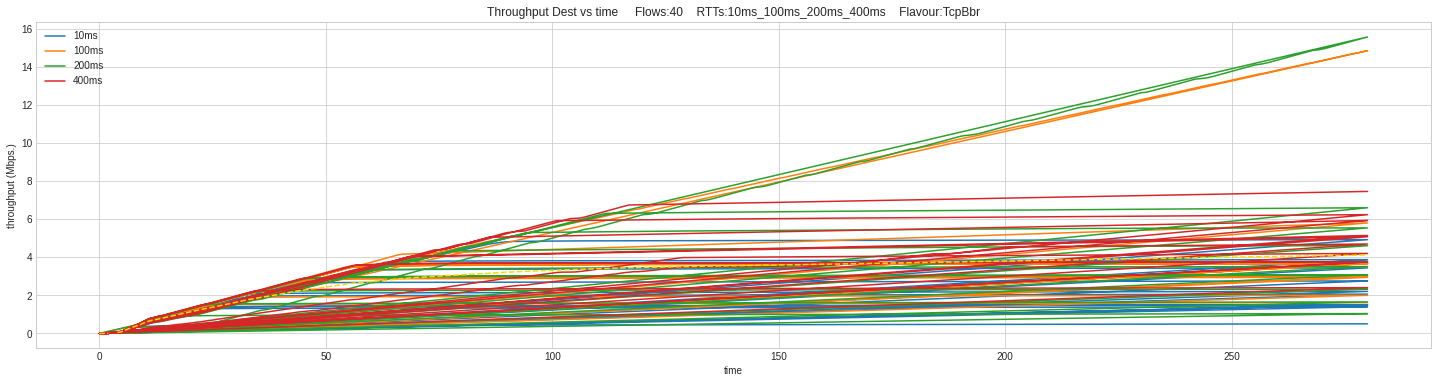

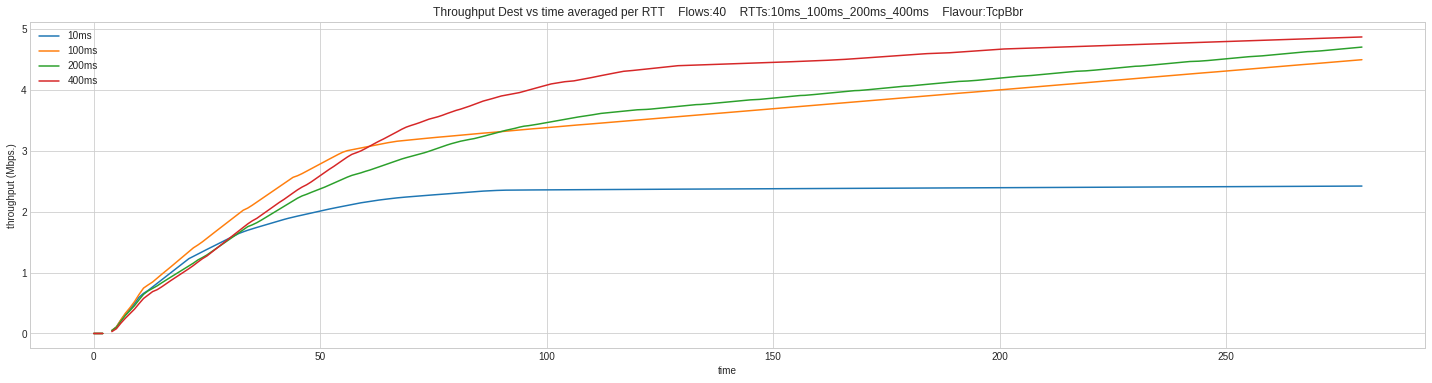

In [53]:
pktSize = 1400
# SIM 1
main(flavour = "TcpBbr", 
     time = 300, 
     noOfSource = 40, 
     total_access_bandwidth = "120Mbps", 
     RTTs = "10ms_100ms_200ms_400ms",
     bottleneck_bandwidth = "100Mbps",
     bottleneck_delay = "1ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     enableBottleneckTrace = 0,
     log_scale=0, 
     run_simul = "no",
     part = 0
     )

2084p


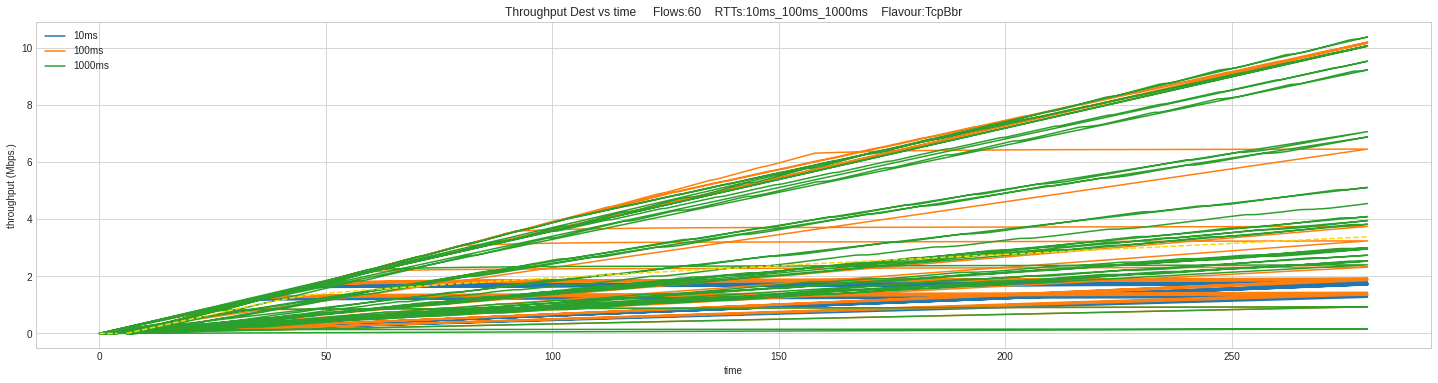

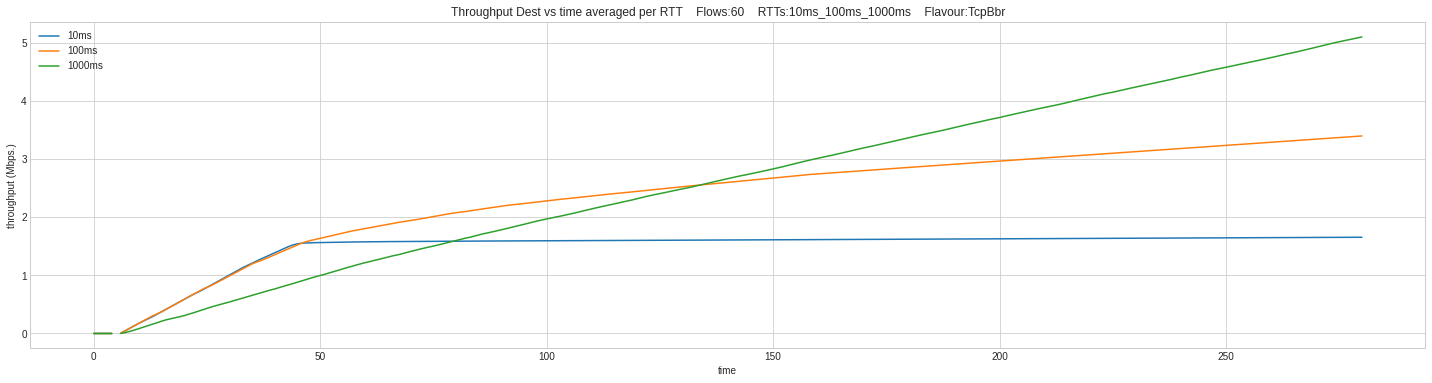

In [54]:
pktSize = 1400
# SIM 2
main(flavour = "TcpBbr", 
     time = 300, 
     noOfSource = 60, 
     total_access_bandwidth = "120Mbps", 
     RTTs = "10ms_100ms_1000ms",
     bottleneck_bandwidth = "100Mbps",
     bottleneck_delay = "1ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     enableBottleneckTrace = 0,
     log_scale=0, 
     run_simul = "no",      
     part = 0
     )

the maths of internet cong control - R shrikanth

2084p


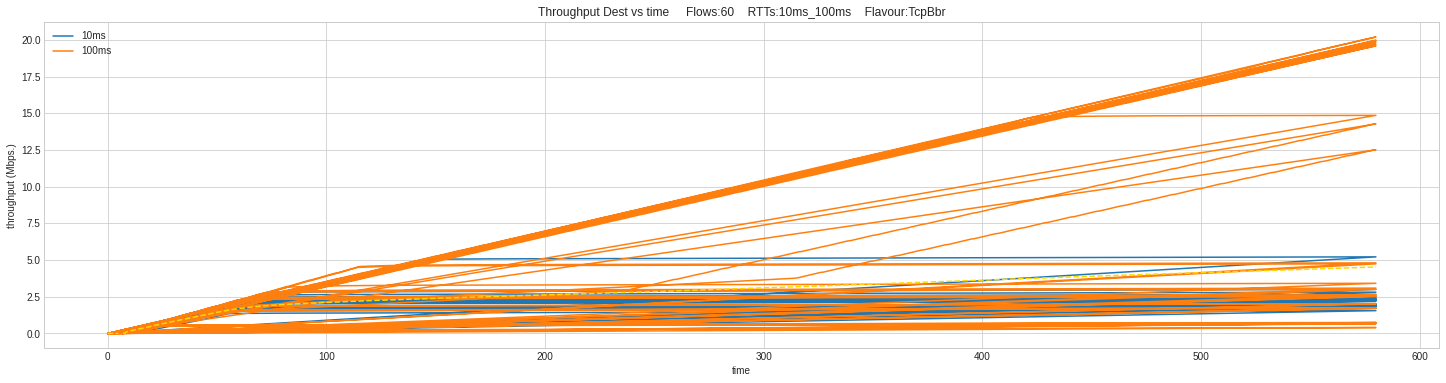

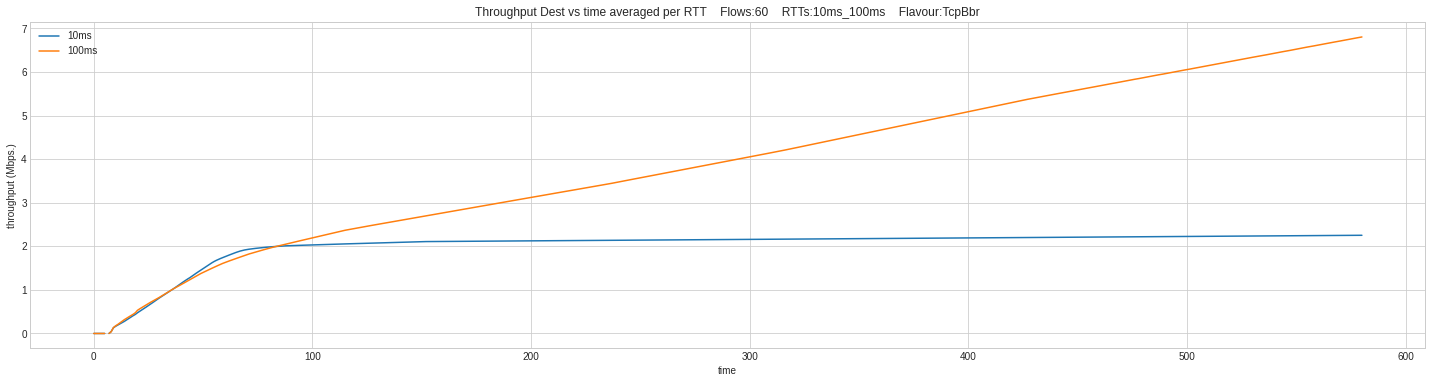

In [55]:
pktSize = 1400
# SIM 3
main(flavour = "TcpBbr", 
     time = 600, 
     noOfSource = 60, 
     total_access_bandwidth = "120Mbps", 
     RTTs = "10ms_100ms",
     bottleneck_bandwidth = "100Mbps",
     bottleneck_delay = "1ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     enableBottleneckTrace = 0,
     log_scale=0, 
     run_simul = "no",      
     part = 0)

In [ ]:
pktSize = 1400
# SIM 4
main(flavour = "TcpBbr", 
     time = 200, 
     noOfSource = 60, 
     total_access_bandwidth = "120Mbps", 
     RTTs = "10ms",
     bottleneck_bandwidth = "100Mbps",
     bottleneck_delay = "40ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     enableBottleneckTrace = 0,
     log_scale=0, run_simul = "no",      part = 0
     )

In [ ]:
pktSize = 1400
# SIM 5
main(flavour = "TcpBbr", 
     time = 200, 
     noOfSource = 60, 
     total_access_bandwidth = "120Mbps", 
     RTTs = "100ms",
     bottleneck_bandwidth = "100Mbps",
     bottleneck_delay = "40ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     enableBottleneckTrace = 0,
     log_scale=0, 
     run_simul = "no",      
     part = 0
     )

In [ ]:
pktSize = 1400
# SIM 6
main(flavour = "TcpBbr", 
     time = 200, 
     noOfSource = 60, 
     total_access_bandwidth = "120Mbps", 
     RTTs = "200ms",
     bottleneck_bandwidth = "100Mbps",
     bottleneck_delay = "40ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     enableBottleneckTrace = 0,
     log_scale=0, run_simul = "no",      part = 0
     )

In [ ]:
pktSize = 1400
# SIM 7
main(flavour = "TcpBbr", 
     time = 200, 
     noOfSource = 80, 
     total_access_bandwidth = "120Mbps", 
     RTTs = "10ms",
     bottleneck_bandwidth = "100Mbps",
     bottleneck_delay = "40ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     enableBottleneckTrace = 0,
     log_scale=0, 
     run_simul = "no",      
     part = 0
     )

In [ ]:
pktSize = 1400
# SIM 8
main(flavour = "TcpBbr", 
     time = 200, 
     noOfSource = 80, 
     total_access_bandwidth = "120Mbps", 
     RTTs = "100ms",
     bottleneck_bandwidth = "100Mbps",
     bottleneck_delay = "40ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     enableBottleneckTrace = 0,
     log_scale=0, 
     run_simul = "no",      
     part = 0
     )

In [ ]:
pktSize = 1400
# SIM 9
main(flavour = "TcpBbr", 
     time = 200, 
     noOfSource = 80, 
     total_access_bandwidth = "120Mbps", 
     RTTs = "200ms",
     bottleneck_bandwidth = "100Mbps",
     bottleneck_delay = "40ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     enableBottleneckTrace = 0,
     log_scale=0, 
     run_simul = "no",      
     part = 0
     )